References:
- https://towardsdatascience.com/modeling-exponential-growth-49a2b6f22e1f
- https://towardsdatascience.com/modeling-logistic-growth-1367dc971de2
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5348083/
- Us-Only Data: https://github.com/nytimes/covid-19-data

# Load the data

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from csaps import csaps

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import matplotlib.patches as patches

In [2]:
dfconf = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
dfdied = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
dfrcvd = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")

In [3]:
display(dfconf.head())
display(dfdied.head())
display(dfrcvd.head())

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,110,110,120,170,174,237,273,281,299,349
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,186,197,212,223,243,259,277,304,333,361
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,409,454,511,584,716,847,986,1171,1251,1320
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,267,308,334,370,376,390,428,439,466,501
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,4,5,7,7,7,8,8,8,10,14


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,4,4,4,4,4,4,6,6,7,7
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,8,10,10,11,15,15,16,17,20,20
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,26,29,31,35,44,58,86,105,130,152
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,3,3,6,8,12,14,15,16,17,18
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,0,0,2,2,2,2,2,2,2,2


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,2,2,2,2,5,5,10,10,10,15
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,31,31,33,44,52,67,76,89,99,104
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,29,31,31,37,46,61,61,62,90,90
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,1,1,1,10,10,10,10,16,21,26
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,0,0,0,0,1,1,1,1,2,2


In [4]:
def logistic(t, a, b, c):
    return c/(1 + a * np.exp(-b*t))

def smoother(df_in, col="Deaths", smooth_amount=0.2):
    y = df_in[col]
    x = y.index

    fit_x = np.arange(len(y))
    fit_y = csaps(fit_x, y, fit_x, smooth=smooth_amount)

    # Add to dataframe and save
    temp = pd.DataFrame(index=x)
    temp['Smoother'] = fit_y.astype(int)
    
    return df_in.join(temp, how="left")

def local_max(data, thresh=None, x=[], min_peak_separation=None):
    '''Find local maxima
    Input:
       data       - Amplitude data for peak searching
       thresh     - Finds peaks in data ABOVE this level
       x          - x-axis data, or []
       dx         - Minimum x-axis peak separation, or []
       plots      - 1 = plots, 0 = no plots (optional)
    Output:
       mxInds     - Indices of maxima
       mxVals     - Amplitudes of correspondin maxima
    
    Notes:
       1. When dx = [], or omitted, ALL peaks above threshold will be found.
       2. When the x = [], or omitted, equispaced data are assumed


    # Example
        data = np.array([1,2,3,4,5,4,3,4,5,4,3,2,1])

        x = np.arange(len(data))
        x[3] = x[3] = x[2]

        min_peak_separation = 2

        print(local_max(data, min_peak_separation=2, x=x))

        >>> ([4, 8], [5, 5])

    '''
    y = data.copy()

    if thresh != None:
        y[y < thresh] = -1e-50

    dy = np.diff(y)
    d2y = np.diff(dy)

    # Find the maxima
    dyChSign  = [int(x) for x in (dy <= 0)]                    # Find where dy changes sign
    temp1     = np.diff(dyChSign)                     # Find where dy changes sign form pos to neg
    mxInds    = np.intersect1d(np.where(temp1 > 0), np.where(d2y < 0)) + 1;     # +1 accounts for the diff
    mxVals    = y[mxInds]

    if min_peak_separation is not None:
        if len(x) == 0:
            xMaxVals = mxInds
        else:
            xMaxVals = x[mxInds]

        df        = np.diff(xMaxVals);
        fd        = np.where(np.abs(df) > min_peak_separation)[0]; # find large separations --> next sh2 region
        intervals = len(fd)+1; # Number of regions
        inds      = [-1] + list(fd) + [len(mxInds)-1];  # Set up indices of intervals

        pkVals2 = []
        pkInds2 = []
        for i in range(intervals):
            indx    = np.arange(inds[i]+1, inds[i+1]+1); # The intervals in Times y array
            windLo  = mxInds[indx[0]];
            windHi  = mxInds[indx[-1]]; # Window the intervals
            temp = y[windLo:windHi+1]
            d1 = max(temp)
            d2 = np.argmax(temp) # Take max in interval

            pkVals2.append(d1)
            pkInds2.append(windLo + d2);

        mxInds = pkInds2;
        mxVals = pkVals2;

    return mxInds, mxVals


In [5]:
def plot_status(fraction_to_midpoint, title_text='', plot_size=(8, 4)):
    n_pts = 200
    ylim_bounds = 7
    x = np.linspace(-ylim_bounds, ylim_bounds, n_pts)
    y = logistic(x, 1, 1, 1)

    dx = np.diff(y, prepend = 0)
    d2x = np.diff(dx, prepend = 0)

    maxInds, maxVals = local_max(d2x, min_peak_separation=100)
    maxInds2, maxVals2 = local_max(-d2x, min_peak_separation=100)

    fig = plt.figure(figsize=plot_size)
    ax = fig.add_subplot(111)

    # Plot Logistic
    ax.plot(x, y, '#cdcdcd', lw=10)

    ax2 = ax.twinx()
    # ax2.plot(x, dx, 'orange', alpha=1)
    # ax2.plot(x, d2x, 'blue', alpha=1)

    # ax2.axhline(y=0, color='w', linestyle='-', alpha=0.2)

    pt_A = x[maxInds[0]-2]
    pt_B = x[maxInds2[0]-1]

    ax.vlines(0, ymin=0, ymax=1, linewidth=1, color='gray', alpha=0.2)
    # ax.vlines(pt_A, ymin=0, ymax=1, linewidth=2, color='r')
    # ax.vlines(pt_B, ymin=0, ymax=1, linewidth=2, color='r')

    active_point = pt_A + np.abs(pt_A)*fraction_to_midpoint

    active_x = x[x <= active_point]
    active_y = y[:len(active_x)]
    
    # Plot logistic progress
    ax.plot(active_x, active_y, 'b', lw=8)
    # ax.vlines(active_point, ymin=0, ymax=1, linewidth=2, color='r')

    # Plot rectangle colors
    red = '#e03531'
    yellow = '#f0bd27'
    green = '#51b364'
    alpha = 0.65
    rect_1 = patches.Rectangle((-ylim_bounds, 0), pt_A - -ylim_bounds, 1, color=red, alpha=alpha)
    rect_2 = patches.Rectangle((pt_A, 0), -2*pt_A, 1, color=yellow, alpha=alpha)
    rect_3 = patches.Rectangle((pt_A-2*pt_A, 0), pt_A - -ylim_bounds, 1, color=green, alpha=alpha)

    ax.add_patch(rect_1)
    ax.add_patch(rect_2)
    ax.add_patch(rect_3)

    plt.xlim([-ylim_bounds, ylim_bounds])
    plt.ylim([0, 1])
    ax.axis('off')
    ax2.axis('off')
    plt.title(title_text, weight='bold', fontsize=14)
    
    txt="Slow Start"
    y_point = 0.05
    plt.figtext(.28, y_point, txt, wrap=True, horizontalalignment='center', fontsize=14)
    
    txt="Fast Growth"
    plt.figtext(.51, y_point, txt, wrap=True, horizontalalignment='center', fontsize=14)
    
    txt="Flattening"
    plt.figtext(.71, y_point, txt, wrap=True, horizontalalignment='left', fontsize=14)
        
    # txt="Time -->"
    # plt.figtext(.51, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=14)
    
    txt="Deaths -->"
    plt.figtext(.115, 0.5, txt, wrap=True, horizontalalignment='center', fontsize=14, rotation=90)

    plt.show()
    

def find_fraction_to_midpoint(data):
    """
    # If there's a max:
    # 1. Find last zero of neg before max if a max exists
    # 2. Find max
    # 3. Find any non-positive value after max

    """

    data[data < 0] = 0 # No need for negative values

    # Find maxima
    maxInds, maxVals = local_max(data, min_peak_separation=100)

    if maxInds != []:

        # Did it cross zero on the right yet?
        # Find first zero-crossing (if any) beyond maxInds
        delta_to_pt_B = np.where(data[maxInds[0]:] <= 0)[0]
        if len(delta_to_pt_B):
            pts_to_end = (len(data) - (delta_to_pt_B[0] + maxInds[0]))

            # Percentage of mid-region
            fraction_to_midpoint = 1 + pts_to_end / delta_to_pt_B[0]
        else:
            # Find early zero crossing
            idx_last_early_zero = np.where(data == 0)[0][-1]

            # Inds from last early zero to point A
            inds_to_A = maxInds[0] - idx_last_early_zero

            days_beyond_pt_A = len(data) - maxInds[0]

            fraction_to_midpoint = days_beyond_pt_A / inds_to_A

    return fraction_to_midpoint

def plot_slopes(d, country, offset=40):
    fig = plt.figure(figsize=(14, 6))
    ax = fig.add_subplot(111)

    d[offset:].Smoother.plot(ax=ax, color='red', lw=5, alpha=1)

    plt.legend(loc=2)
    ax2 = ax.twinx()
    d[offset:].dx.plot(ax=ax2, color='orange', lw=4, alpha=0.8)
    d[offset:].d2x.plot(ax=ax2, color='blue', lw=2, alpha=0.7)

    maxInds, maxVals = local_max(d[offset:].d2x.values, min_peak_separation=100)
    d[offset:].d2x[maxInds].plot(ax=ax2, marker='o', ms=12)

    ax2.axhline(y=0, color='g', linestyle='--')

    ax2.set_ylabel('Number of Deaths')
    ax2.set_ylabel('Number of New Deaths Per Day')

    plt.legend(loc=9)
    plt.title(country)
    plt.show();
    
    
NON_DATE_COLS = ["Province/State", "Country/Region", "Lat", "Long", "Country"]
def prepare_data(df):

    date_cols = [c for c in df.columns if c not in NON_DATE_COLS]

    # Collapse by country in the case where there are multiple
    # regions in a country
    df_plot = dfdied.groupby(by="Country/Region").sum()

    # Sort to position highest numberss first
    df_plot.sort_values(by=date_cols[-1], inplace=True, ascending=False)

    threshold_for_total_events = 200
    df_plot = df_plot[df_plot[date_cols[-1]] > threshold_for_total_events].reset_index()#[date_cols]

    df_plot = df_plot.rename(columns={"Country/Region": "Country"})[["Country"] + date_cols]
    return df_plot

def make_dervatives(df, country):
    date_cols = [c for c in df.columns if c not in NON_DATE_COLS]
    data = df[df.Country == country][date_cols].T
    data.index = pd.to_datetime(data.index)
    d = pd.DataFrame(index=pd.to_datetime(pd.date_range(data.index.values[0], periods=len(data)+7, freq='d').strftime('%m/%d/%Y')))
    d = d.join(data)
    d.columns = ['Deaths']

    # Add new column, "Smoother", to dataframe
    d = smoother(d.loc[d['Deaths'].notnull()], smooth_amount=.26)
    d['Smoother'] = d.Smoother.round().astype(int)

    d['dx'] = np.diff(d.Smoother, prepend=d.Deaths[0])
    d['d2x'] = np.diff(d.dx, prepend=d.Smoother[0])
    return d

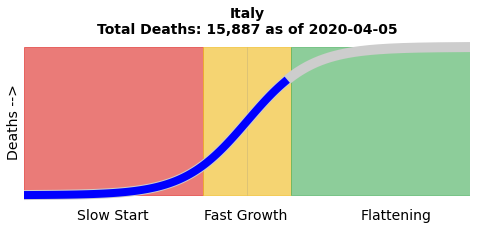

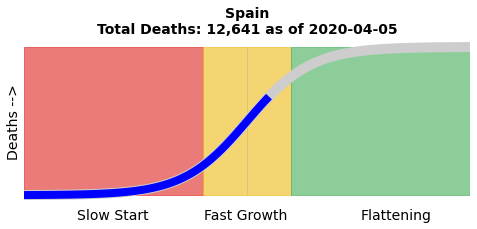

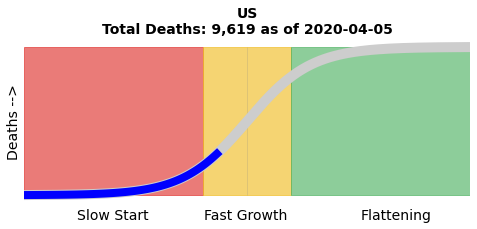

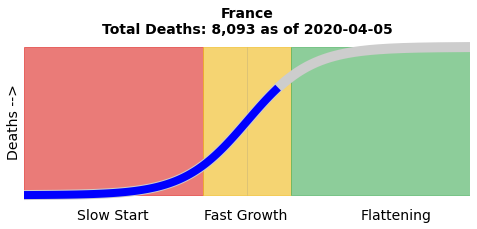

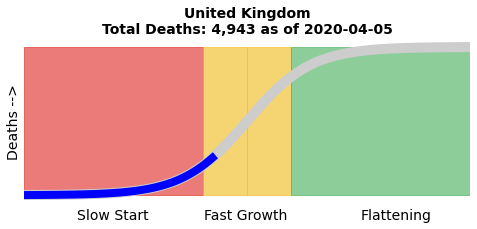

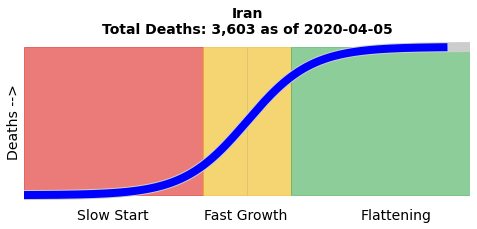

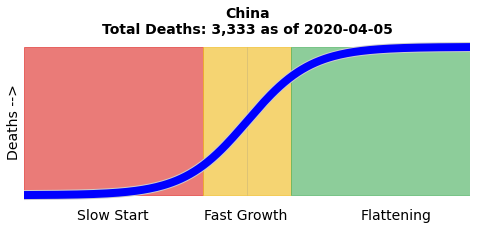

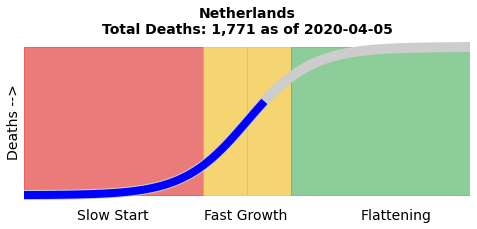

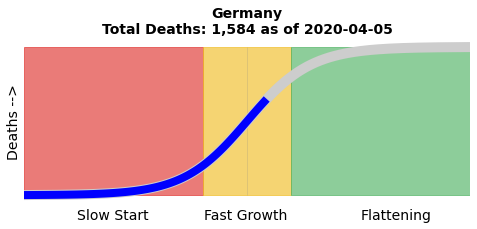

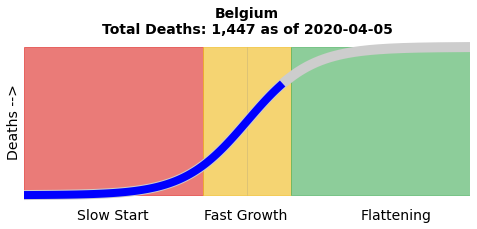

In [7]:
# Create the data
df = prepare_data(dfdied)
dfd = make_dervatives(df, 'Italy')

countries = df.Country.values
last_date = dfd.tail(1).columns[-1]

for country in countries[:10]:
    dfd = make_dervatives(df, country)
    
    title_text = "{:}\nTotal Deaths: {:,} as of {:}".format(country, int(dfd.Deaths[-1]), str(dfd.index[-1])[:10])
    
    plot_status(find_fraction_to_midpoint(dfd.d2x.values), title_text, plot_size=(8, 3))
    plt.show()
    
    # Show the slope plots for verification/investigation
    #plot_slopes(d, country)